# Inferencing finetuned YoloV5

In [ ]:
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from PIL import Image
from tqdm import tqdm

from yoloNpdOCR.config import Config
from yoloNpdOCR.my_yolo_ocr import MyYoloOCR

tqdm.pandas()

In [ ]:
cnfg = Config()

### Make Data Df ####

In [ ]:
all_files = []
for file in [f for f in glob.glob(f"{cnfg.test_data_path}*.jpg")] + [
    f for f in glob.glob(f"{cnfg.test_data_path}*.png")
]:
    all_files.append(file)

In [ ]:
df_dict = {
    "images": [os.path.basename(x) for x in all_files],
    "labels": [os.path.splitext(os.path.basename(x))[0].upper() for x in all_files],
}

In [ ]:
df = pd.DataFrame(df_dict)

In [ ]:
df.head()

,images,labels
0,hgaa7034.jpg,HGAA7034
1,ancl550.jpg,ANCL550
2,hrod819.jpg,HROD819
3,map7563.jpg,MAP7563
4,mbcl600.jpg,MBCL600


In [ ]:
df["labels"] = df.labels.apply(lambda x: x.replace("-", ""))  # process labels

### Main Pipeline ####

In [ ]:
yolo_ocr = MyYoloOCR(weights_file_location=cnfg.weights_path)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /home/rohit/.cache/torch/hub/master.zip
YOLOv5 🚀 2024-5-8 Python-3.10.6 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3090, 24258MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7112611 parameters, 0 gradients, 16.1 GFLOPs
Adding AutoShape... 


In [ ]:
sample = df.sample(1).iloc[0]
sample_img_path = f"{cnfg.base_data_path}{sample.images}"
sample_img_path

'../data/np_char_datasets/aba1234.jpg'

In [ ]:
sample_img_path = "../data/eu-license-plates/eu/de/nrw4-5317.jpg"

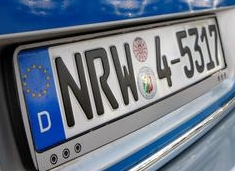

In [ ]:
pil_im = Image.open(sample_img_path)
pil_im

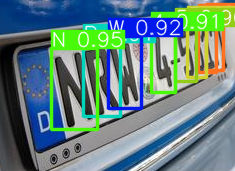

'NRW45311'

In [ ]:
yolo_ocr.get_number_plate_text(img_path=sample_img_path, show_result=True)

## Apply OCR To All Images ##

In [ ]:
def apply_ocr_to_all(x: str, ocr):
    """
    x: image name
    """
    img_path = f"{cnfg.test_data_path}{x}"
    res = ocr.get_number_plate_text(img_path)

    return res

In [ ]:
df["yolo_res"] = df.images.progress_apply(lambda x: apply_ocr_to_all(x, yolo_ocr))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 61.96it/s]


In [ ]:
df.head()

,images,labels,yolo_res
0,hgaa7034.jpg,HGAA7034,HGAA7034
1,ancl550.jpg,ANCL550,ANCL550
2,hrod819.jpg,HROD819,HR0D819
3,map7563.jpg,MAP7563,MAP7563
4,mbcl600.jpg,MBCL600,MBCL600


In [ ]:
df["yolo_res_match"] = df.apply(lambda x: 1 if x.labels == x.yolo_res else 0, axis=1)

In [ ]:
df.yolo_res_match.value_counts(normalize=True)

yolo_res_match
1    0.882353
0    0.117647
Name: proportion, dtype: float64

In [ ]:
df[df.yolo_res_match == 0]

,images,labels,yolo_res,yolo_res_match
2,hrod819.jpg,HROD819,HR0D819,0
12,o2.jpg,O2,0O2,0
19,fbck80.jpg,FBCK80,FBCK8D,0
21,nrw4-5317.jpg,NRW45317,NRW45311,0
38,aaaa111.jpg,AAAA111,AAAA1III,0
50,m230.png,M230,23,0
